In [1]:
## Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")


In [2]:
## Load dataset.
## It's already splitted and cleaned as
'''
pre_covid = merged.loc[merged['ev_year'] < 2020]
post_covid = merged.loc[merged['ev_year'] >= 2020]
pre_covid = pre_covid.reset_index().drop(columns=['index'])

strat_kfold = StratifiedGroupKFold(n_splits = 5, shuffle=True, random_state=412)  # Validation and test will both be 20% of data, hence 5 splits
splits = strat_kfold.split(pre_covid, pre_covid['damage'], pre_covid['ev_id'].astype(str))   # Grouped by 'ev_id', stratified by 'damage'

# data_test <-- test set from the first fold (20% of data)
# data_test <-- test set from the second fold (20% of data)
# data_train <- remaining data (60%)

for i, (train_index, test_index) in enumerate(splits):
    if i==0:
        data_test = pre_covid.iloc[test_index]
        data_train = pre_covid.iloc[train_index]
    elif i==1:
        data_val = pre_covid.iloc[test_index]
        data_train.drop(test_index)
        break

'''

## Randomly sampled, stratified along with the 'damage'
## Train : Val : Test = 6:2:2 (Precovid)


df_train = pd.read_csv('../data/ntsb_processed/ntsb_train_cleaned.csv')
df_val = pd.read_csv('../data/ntsb_processed/ntsb_val_cleaned.csv')
df_test = pd.read_csv('../data/ntsb_processed/master_test.csv')
df_post_covid = pd.read_csv('../data/ntsb_processed/master_post_covid.csv')


In [3]:
def show_difference_between_two_df(df1 : pd.DataFrame, df2: pd.DataFrame):
    list1 = df1.columns  # Your first list
    list2 = df2.columns # Your second list

    # Convert to Python sets
    set1 = set(list1)
    set2 = set(list2)

    # Find what's in list1 but not in list2
    only_in_list1 = set1 - set2

    # Find what's in list2 but not in list1
    only_in_list2 = set2 - set1

    print("Only in the first dataframe:", sorted(only_in_list1))
    print("Only in the second dataframe:", sorted(only_in_list2))

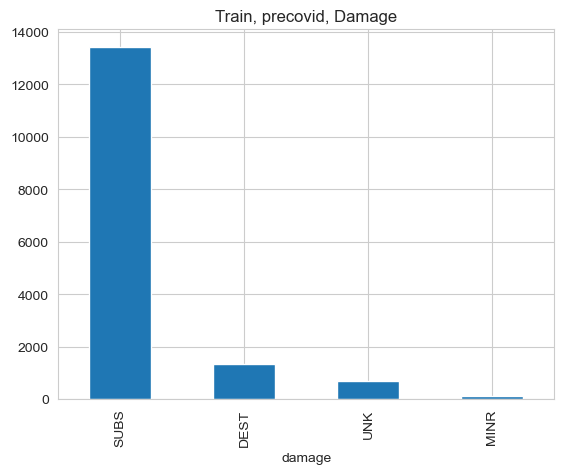

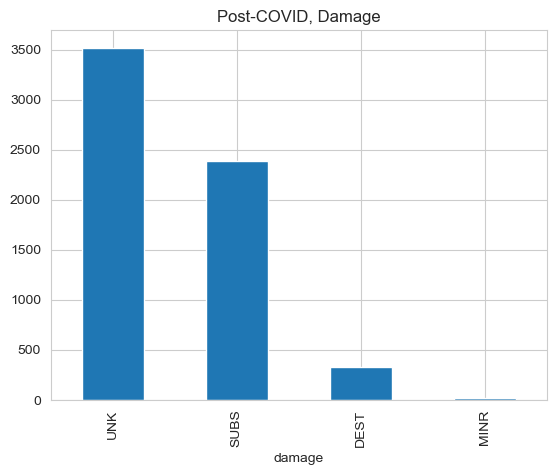

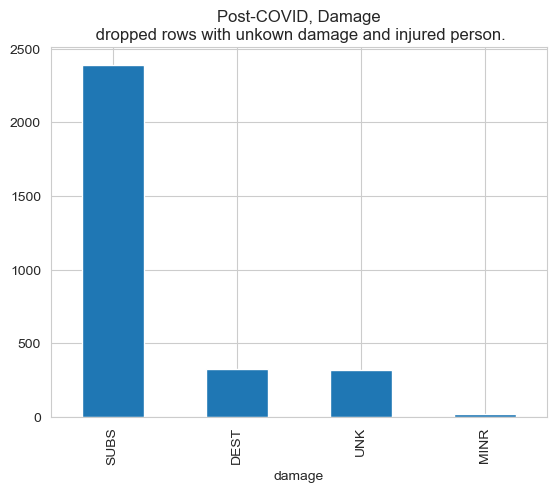

In [4]:
# First plot
df_train['damage'].value_counts().plot(kind='bar')
plt.title('Train, precovid, Damage')
plt.show()  

# Second plot
df_post_covid['damage'].value_counts().plot(kind='bar')
plt.title('Post-COVID, Damage')
plt.show()

# Third plot
condition = (df_post_covid['damage'] == 'UNK') & (df_post_covid['acft_injured_person_count'].isna())
df_post_covid = df_post_covid.loc[~condition]
df_post_covid['damage'].value_counts().plot(kind='bar')
plt.title('Post-COVID, Damage\n dropped rows with unkown damage and injured person.')
plt.show()


In [19]:
# change latitude and longitude to numeric value

for data in [df_train, df_val]:
    for i in ['latitude','longitude']:
        data[i] = data[i].replace('other/unknown', np.nan)
    data = data.dropna().reset_index()

    # Strip last character (N/S or E/W) and convert to int
    data['latitude'] = data['latitude'].str[:-1].astype(int)
    data['longitude'] = data['longitude'].str[:-1].astype(int)

In [6]:
features = ['latitude', 'longitude',    # need to change to numeric value first
       'apt_dist', 'gust_kts', 'altimeter',
       'aircraft_count', 'num_eng', 'days_since_insp', 'light_cond_DAYL', 'light_cond_DUSK',
       'light_cond_NDRK', 'light_cond_NITE', 'light_cond_other/unknown',
       'BroadPhaseofFlight_Air', 'BroadPhaseofFlight_Ground',
       'BroadPhaseofFlight_Landing', 'BroadPhaseofFlight_Takeoff',
       'BroadPhaseofFlight_other/unknown', 'eng_type_REC', 'eng_type_TF',
       'eng_type_TP', 'eng_type_TS', 'eng_type_other/unknown', 'far_part_091',
       'far_part_121', 'far_part_135', 'far_part_137', 'far_part_PUBU',
       'far_part_other/unknown', 'acft_make_beech', 'acft_make_bell',
       'acft_make_boeing', 'acft_make_cessna', 'acft_make_mooney',
       'acft_make_other/unknown', 'acft_make_piper',
       'acft_make_robinson helicopter', 'acft_category_AIR',
       'acft_category_HELI', 'acft_category_other/unknown', 'homebuilt_N',
       'homebuilt_Y', 'homebuilt_other/unknown', 'fixed_retractable_FIXD',
       'fixed_retractable_RETR', 'fixed_retractable_other/unknown',
       'second_pilot_N', 'second_pilot_Y', 'second_pilot_other/unknown']

categorical_features = ['aircraft_count',
                     'light_cond_DAYL','light_cond_DUSK','light_cond_NDRK','light_cond_NITE','light_cond_other/unknown',
                     'BroadPhaseofFlight_Air','BroadPhaseofFlight_Ground','BroadPhaseofFlight_Landing','BroadPhaseofFlight_Takeoff','BroadPhaseofFlight_other/unknown',
                     'eng_type_REC','eng_type_TF','eng_type_TP','eng_type_TS','eng_type_other/unknown',
                     'far_part_091','far_part_121','far_part_135','far_part_137','far_part_PUBU','far_part_other/unknown',
                     'acft_make_beech','acft_make_bell','acft_make_boeing','acft_make_cessna','acft_make_mooney','acft_make_other/unknown','acft_make_piper',
                     'acft_make_robinson helicopter','acft_category_AIR','acft_category_HELI','acft_category_other/unknown',
                     'homebuilt_N','homebuilt_Y','homebuilt_other/unknown',
                     'fixed_retractable_FIXD','fixed_retractable_RETR','fixed_retractable_other/unknown',
                     'second_pilot_N','second_pilot_Y','second_pilot_other/unknown']

In [12]:
df_train = df_train[df_train['gust_kts']<800]

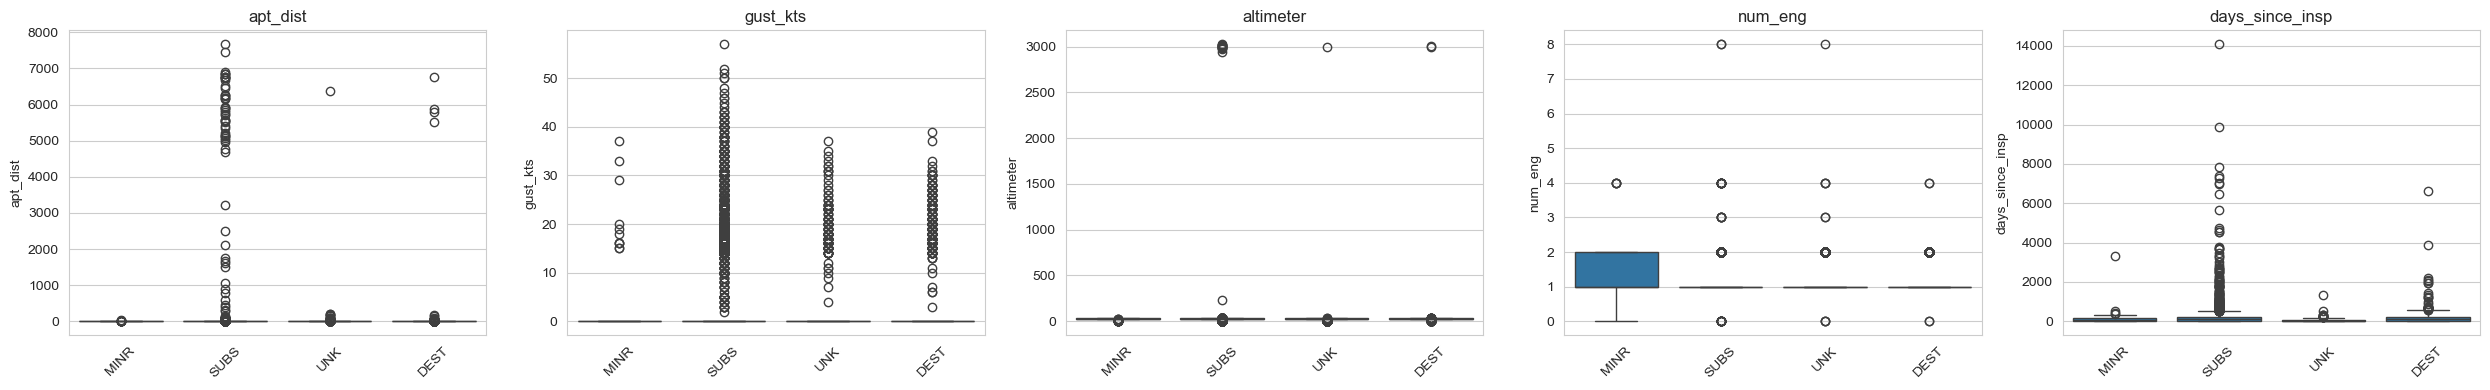

In [14]:
target = 'damage'
# List of numerical features
num_features = ['apt_dist', 'gust_kts', 'altimeter', 'num_eng','days_since_insp']



# Create a 1-row grid of box plots
fig, axes = plt.subplots(1, len(num_features), figsize=(5 * len(num_features), 4))

for i, feature in enumerate(num_features):
    sns.boxplot(data=df_train, x=target, y=feature, ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

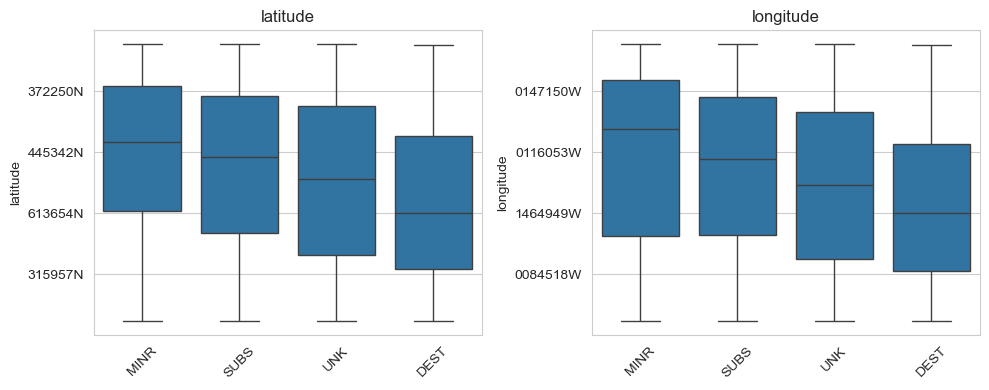

In [15]:
num_features =['latitude', 'longitude']


# Create a 1-row grid of box plots
fig, axes = plt.subplots(1, len(num_features), figsize=(5 * len(num_features), 4))

for i, feature in enumerate(num_features):
    sns.boxplot(data=df_train, x=target, y=feature, ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Reduce number of yticks
    y_min, y_max = axes[i].get_ylim()
    axes[i].set_yticks(np.linspace(y_min, y_max, 6))  
plt.tight_layout()
plt.show()

In [9]:
num_features = ['apt_dist', 'gust_kts', 'altimeter', 'num_eng', 'days_since_insp', 'latitude', 'longitude']

In [69]:
## Function for showing histogram in categorical features per damage level.

def show_barplot(categorical_features : list[str], df : pd.DataFrame):
    damage_levels = ['DEST', 'SUBS', 'MINR', 'UNK']
    colors = {'DEST': 'red', 'MINR': 'skyblue', 'SUBS': 'blue', 'UNK': 'cyan'}

    
    
    for feature in categorical_features:
        _, axes = plt.subplots(1, 4, figsize=(5 * 4, 4), squeeze=False)

        for j, dmg in enumerate(damage_levels):
            ax = axes[0, j]
            ax.bar(df[df['damage']==dmg][feature].value_counts(normalize=True).keys(), 
                    df[df['damage']==dmg][feature].value_counts(normalize=True).values, 
                    color=colors[dmg])
            ax.set_title(f"{feature}\n{dmg}", fontsize=10)
            ax.set_ylim(0, 1)
            # ax.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()
        


# show_barplot([f for f in categorical_features if f.startswith('second')], 
#              df_train)

In [16]:
# Drop Unknown damage
df_train = df_train[df_train[target] != 'UNK']


# Extract features and target from the training DataFrame.
X_train = df_train[features]
y_train = df_train[target]


label_order = ['MINR', 'SUBS', 'DEST']
# label_map = {'MINR':0, 'SUBS' :0, 'DEST' :1} # Binary
label_map = {'MINR':0, 'SUBS' :1, 'DEST' :2} # Ternary
y_train_encoded = y_train.map(label_map)

In [70]:
'''
## Do regression in RandomForestClassifier without selecting features.
## This paragraph is originated from the problem session 10 in Erdos 2025 summer data science boot camp.
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

# Extract features and target from the training DataFrame.
X_train = df_train[features]
y_train = df_train[target]

# As target values are 'MINR', 'SUBS', ..., transform into numerical; 0,1,2,3
# UNKNOWN has been dropped already.


# Define the parameter ranges.
max_depths = range(1, 11)            # 1 to 10 inclusive
n_estimators_options = [100, 300, 500]

# Shape: (number of max_depth options, number of n_estimators options) = (10, 2)
f1_arr = np.zeros((len(max_depths), len(n_estimators_options)))

# Set up 5-fold cross-validation.
kf = KFold(n_splits=5, shuffle=True, random_state=216)

# Loop over all combinations of max_depth and n_estimators.
for i, max_depth in enumerate(max_depths):
    for j, n_estimators in enumerate(n_estimators_options):
        fold_f1 = []  # To store Accuracy for each fold.
        
        # Perform cross-validation.
        for train_index, test_index in kf.split(X_train):
            # If X is a DataFrame, you can index directly.
            X_tt, X_ho = X_train.iloc[train_index], X_train.iloc[test_index]
            y_tt, y_ho = y_train_encoded.iloc[train_index], y_train_encoded.iloc[test_index]
            


            # Instantiate and train the regressor.
            model = RandomForestClassifier(max_depth=max_depth, 
                                          n_estimators=n_estimators, 
                                          random_state=216)
            model.fit(X_tt, y_tt)
            
            # Predict and compute accuracies for this fold.
            y_pred = model.predict(X_ho)
            f1 = f1_score(y_ho, y_pred, average='weighted')
            fold_f1.append(f1)
        # Store the average accuracy for the current parameter combination.
        f1_arr[i, j] = np.mean(fold_f1)
        

print("Average cross-validation Accuracies for each combination:")
print(f1_arr)

# To get the best parameters:
best_idx = np.unravel_index(np.argmax(f1_arr), f1_arr.shape)
best_max_depth = list(max_depths)[best_idx[0]]
best_n_estimators = n_estimators_options[best_idx[1]]
print(f"Best parameters: max_depth={best_max_depth}, n_estimators={best_n_estimators}")
'''

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

grid_cv = GridSearchCV(RandomForestClassifier(), 
                          param_grid = {'max_depth':range(1, 11),
                                        'n_estimators':[100,300,500,700, 900]}, # and n_estimators here
                          scoring = 'f1_macro', 
                          cv = 5) # put the number of cv splits here


grid_cv.fit(X_train,y_train_encoded)

ValueError: 
All the 250 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/ensemble/_forest.py", line 360, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/utils/validation.py", line 973, in check_array
    array = array.astype(new_dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/pandas/core/generic.py", line 6643, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/pandas/core/internals/managers.py", line 430, in astype
    return self.apply(
           ^^^^^^^^^^^
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/pandas/core/internals/managers.py", line 363, in apply
    applied = getattr(b, f)(**kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/pandas/core/internals/blocks.py", line 758, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/pandas/core/dtypes/astype.py", line 237, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/pandas/core/dtypes/astype.py", line 182, in astype_array
    values = _astype_nansafe(values, dtype, copy=copy)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/pandas/core/dtypes/astype.py", line 133, in _astype_nansafe
    return arr.astype(dtype, copy=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: '445951N'

--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/ensemble/_forest.py", line 360, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/utils/validation.py", line 973, in check_array
    array = array.astype(new_dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/pandas/core/generic.py", line 6643, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/pandas/core/internals/managers.py", line 430, in astype
    return self.apply(
           ^^^^^^^^^^^
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/pandas/core/internals/managers.py", line 363, in apply
    applied = getattr(b, f)(**kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/pandas/core/internals/blocks.py", line 758, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/pandas/core/dtypes/astype.py", line 237, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/pandas/core/dtypes/astype.py", line 182, in astype_array
    values = _astype_nansafe(values, dtype, copy=copy)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/inkeejung/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/pandas/core/dtypes/astype.py", line 133, in _astype_nansafe
    return arr.astype(dtype, copy=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: '381326N'


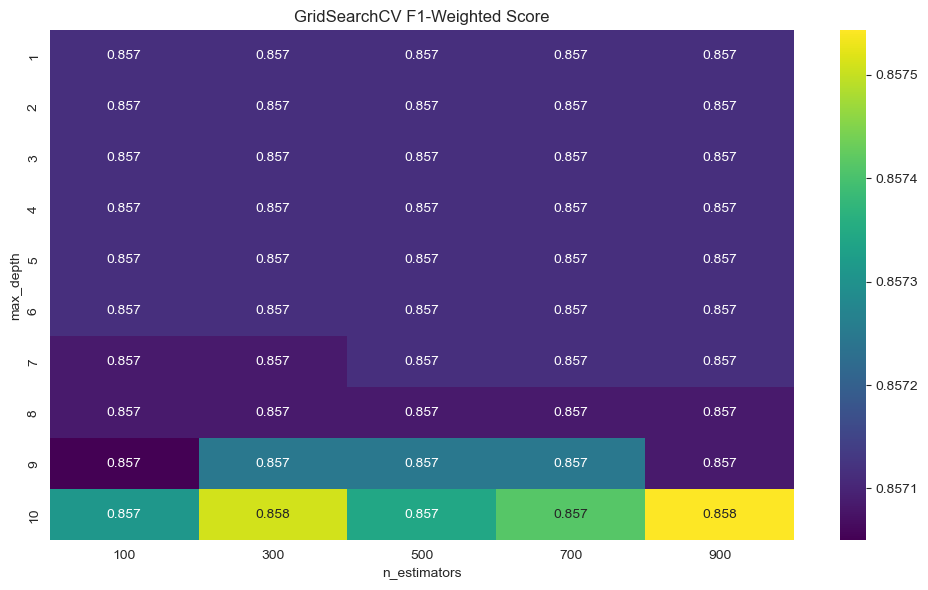

Best Parameters: {'max_depth': 10, 'n_estimators': 900}
Best Weighted F1 Score: 0.8575427100136623


In [ ]:
# Get results into a DataFrame
results = pd.DataFrame(grid_cv.cv_results_)

# Extract relevant columns
scores_matrix = results.pivot(index='param_max_depth', 
                               columns='param_n_estimators', 
                               values='mean_test_score')

plt.figure(figsize=(10, 6))
sns.heatmap(scores_matrix, annot=True, fmt=".3f", cmap='viridis')
plt.title("GridSearchCV F1-Weighted Score")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()
print("Best Parameters:", grid_cv.best_params_)
print("Best Weighted F1 Score:", grid_cv.best_score_)

In [74]:
feature_importance_df = pd.DataFrame({
    'Feature': features,  
    'Importance': grid_cv.best_estimator_.feature_importances_
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Reset index for better readability
feature_importance_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(feature_importance_df)

                             Feature  Importance
0                    days_since_insp    0.122847
1                           apt_dist    0.107757
2                          altimeter    0.105170
3             BroadPhaseofFlight_Air    0.074328
4                     aircraft_count    0.056389
5         BroadPhaseofFlight_Landing    0.053160
6                           gust_kts    0.033192
7             fixed_retractable_RETR    0.031294
8             fixed_retractable_FIXD    0.030683
9                            num_eng    0.030010
10                   light_cond_NDRK    0.028159
11                   light_cond_DAYL    0.021620
12                   light_cond_NITE    0.017420
13           acft_make_other/unknown    0.017407
14                      eng_type_REC    0.016886
15         BroadPhaseofFlight_Ground    0.015670
16        BroadPhaseofFlight_Takeoff    0.015578
17                       eng_type_TP    0.015065
18                    second_pilot_N    0.014851
19                  

In [81]:
print('sum of Importances of features starting with ')
for string in ['acft_make', 'fixed', 'far', 'Broad', 'light', 'home', 'eng']:
    print(f'{string}:', feature_importance_df[feature_importance_df['Feature'].str.startswith(string)]['Importance'].sum())

sum of Importances of features starting with 
acft_make: 0.06629327336850291
fixed: 0.06197620319425125
far: 0.04915721764501919
Broad: 0.16462043797699683
light: 0.0777570590670019
home: 0.01573991994073296
eng: 0.053611867647406594


In [89]:
show_difference_between_two_df(df_train, df_val)

Only in the first dataframe: ['acft_make_boeing']
Only in the second dataframe: ['acft_make_air tractor inc']


In [96]:
df_val['acft_make_boeing'] = False

In [100]:
df_val = df_val[df_val['damage']!='UNK']
x_val = df_val[features] 
y_val = df_val['damage']
y_val_encoded = y_val.map(label_map)


F1 Score (weighted): 0.8754

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.16      0.28        25
           1       0.91      1.00      0.95      3376
           2       1.00      0.04      0.07       312

    accuracy                           0.91      3713
   macro avg       0.97      0.40      0.43      3713
weighted avg       0.92      0.91      0.88      3713



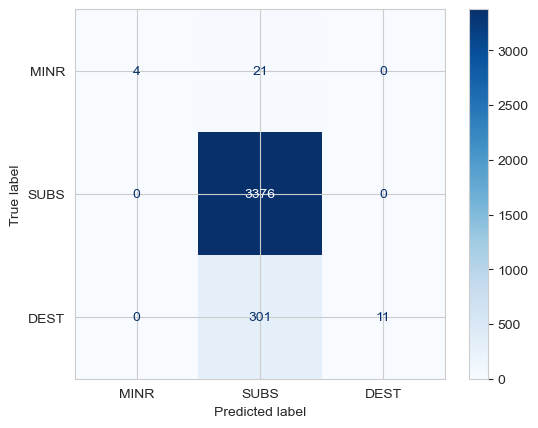

In [102]:

best_rf = grid_cv.best_estimator_

from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict on validation set
y_pred = best_rf.predict(x_val)

# F1 Score (weighted)
f1 = f1_score(y_val_encoded, y_pred, average='macro')
print("F1 Score (macro):", round(f1, 4))

# Classification Report (includes precision, recall, f1 per class)
print("\nClassification Report:")
print(classification_report(y_val_encoded, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_val_encoded, y_pred)
inv_label_map = {v: k for k, v in label_map.items()}
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[inv_label_map[i] for i in range(len(inv_label_map))])
disp.plot(cmap='Blues')


     param_n_estimators param_max_depth  param_min_samples_split  \
132                 100              20                        2   
168                 100              30                        2   
25                  200            None                        2   
26                  500            None                        2   
169                 200              30                        2   
134                 500              20                        2   
24                  100            None                        2   
170                 500              30                        2   
171                 100              30                        5   
135                 100              20                        5   

    param_max_features  mean_test_score  
132               None         0.512457  
168               None         0.511934  
25                None         0.511084  
26                None         0.510487  
169               None         0.509762  

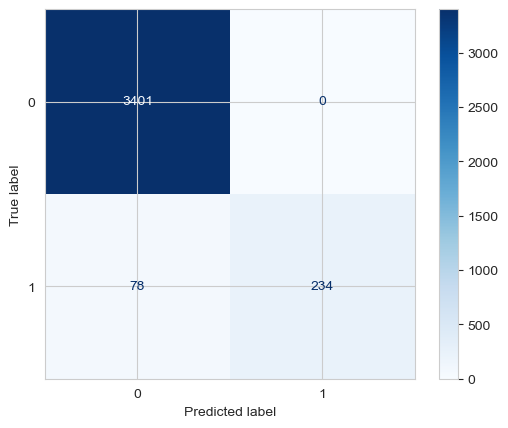

In [110]:
label_map = {'MINR':0, 'SUBS' :0, 'DEST' :1} # binary
y_train_encoded = y_train.map(label_map)
grid_cv = GridSearchCV(RandomForestClassifier(), 
                          param_grid = {
                                        'n_estimators': [100, 200, 500],
                                        'max_depth': [None,5, 10, 20, 30],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'max_features': ['sqrt', 'log2', None]
                                        }   ,
                          scoring = 'f1_macro', 
                          cv = 5)


grid_cv.fit(X_train,y_train_encoded)

# Get results into a DataFrame
results = pd.DataFrame(grid_cv.cv_results_)

top_n = results.sort_values(by='mean_test_score', ascending=False).head(10) # n = 10
print(top_n[[
    'param_n_estimators', 'param_max_depth', 'param_min_samples_split', 
    'param_max_features', 'mean_test_score'
]])


print("Best Parameters:", grid_cv.best_params_)
print("Best Weighted F1 Score:", grid_cv.best_score_)

feature_importance_df = pd.DataFrame({
    'Feature': features,  
    'Importance': grid_cv.best_estimator_.feature_importances_
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Reset index for better readability
feature_importance_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(feature_importance_df.head(10))

y_val_encoded = y_val.map(label_map)


best_rf = grid_cv.best_estimator_

# Predict on validation set
y_pred = best_rf.predict(x_val)

# F1 Score (weighted)
f1 = f1_score(y_val_encoded, y_pred, average='weighted')
print("F1 Score (weighted):", round(f1, 4))

# Classification Report (includes precision, recall, f1 per class)
print("\nClassification Report:")
print(classification_report(y_val_encoded, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_val_encoded, y_pred)
# inv_label_map = {v: k for k, v in label_map.items()}
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')


### Note

If we take damage into ternary ordinal values random forest doesn't work well. See the 0.4 recall score for 'DEST'. Same when it's regarded as binary classification like 'Dest' and 'Non Dest'.


In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

histgrad = HistGradientBoostingClassifier()

param_grid_hist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_iter': [100, 200, 500],
    'max_leaf_nodes': [15, 31, 63],
    'min_samples_leaf': [20, 50, 100]
}

grid_hist = GridSearchCV(
    histgrad,
    param_grid_hist,
    scoring='f1_macro',
    cv=5,
)

grid_hist.fit(X_train,y_train)

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_xgb = GridSearchCV(
    histgrad,
    param_grid_xgb,
    scoring='f1_macro',
    cv=5,
)

grid_xgb.fit(X_train,y_train_encoded)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
param_grid_extra = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'max_features': ['sqrt', 'log2', None]
}



grid_extra = GridSearchCV(
    histgrad,
    param_grid_extra,
    scoring='f1_macro',
    cv=5,
)

grid_extra.fit(X_train,y_train_encoded)
